<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 3148, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 3148 (delta 17), reused 14 (delta 8), pack-reused 3117 (from 3)
Receiving objects: 100% (3148/3148), 86.02 MiB | 19.51 MiB/s, done.
Resolving deltas: 100% (2155/2155), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import pathlib
import re

from kltn import *
from kltn.datasets.lits import Lits, Stage2Dataset2D
from kltn.datasets.get_datasets import get_datasets_lits, convert_to_2D_dataset_v1
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results, visualize_results_stage_1, visualize_ct_slice
from kltn.utils.utils import find_best_slice
from kltn.processing.preprocessing import resize_crop_to_bbox_size, uncrop_to_full_image, resize_image
from kltn.processing.postprocessing import post_trans_stage1, post_processing_stage2
from skimage.transform import resize

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.07% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
2.08% complete (down: 27826.7 kB/s up: 813.1 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[17

In [8]:
import json

path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"
def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

liver_masks_bbox = load_json(path_save_result)

In [9]:
convert_to_2D_dataset_v1(source=config["source_folder_lits"], bbox=liver_masks_bbox, slides=3, save_dir=config["path_save_dataset_2D"]) # 3 slide of 3d and stride 2

Patient 9 processed.
Patient 45 processed.
Patient 121 processed.
Patient 64 processed.
Patient 55 processed.
Patient 114 processed.
Patient 24 processed.
Patient 10 processed.
Patient 75 processed.
Patient 12 processed.
Patient 81 processed.
Patient 54 processed.
Patient 15 processed.
Patient 60 processed.
Patient 35 processed.
Patient 123 processed.
Patient 120 processed.
Patient 28 processed.
Patient 74 processed.
Patient 1 processed.
Patient 68 processed.
Patient 122 processed.
Patient 107 processed.
Patient 8 processed.
Patient 53 processed.
Patient 117 processed.
Patient 99 processed.
Patient 71 processed.
Patient 101 processed.
Patient 7 processed.
Patient 97 processed.
Patient 112 processed.
Patient 2 processed.
Patient 93 processed.
Patient 44 processed.
Patient 88 processed.
Patient 98 processed.
Patient 80 processed.
Patient 86 processed.
Patient 50 processed.
Patient 96 processed.
Patient 57 processed.
Patient 4 processed.
Patient 65 processed.
Patient 47 processed.
Patient

## utils function

In [5]:
def preprocessing_liver(image_ct, mask_liver):
  image, seg = Lits.preprocessing(image_ct, mask_liver, False, normalizations="zscores")
  seg = (seg > 0).astype(np.uint8)

  image, seg = image.astype(np.float32), seg.astype(np.uint8)
  image, seg = torch.from_numpy(image), torch.from_numpy(seg)

  return image, seg

In [6]:
def preprocessing_tumor(compressed_array_path):
  data = Stage2Dataset2D.load_npz(compressed_array_path)
  _image, _seg, bbox = data["image"], data["seg"], data["bbox"]
  image, seg = Stage2Dataset2D.preprocessing(_image, _seg, False, normalizations="zscores")

  liver_mask = (seg > 0).astype(np.uint8)
  image, seg = image.astype(np.float32), (seg == 2).astype(np.uint8)
  image, seg = torch.from_numpy(image), torch.from_numpy(seg)

  return image, seg, liver_mask, bbox

In [7]:
def paste_mask_to_full(mask_pred, bbox, full_shape):
    """
    Đưa mask nhỏ vào lại vị trí cũ trong CT slice full size.

    Parameters:
    - mask_pred: mask 2D đã predict, shape (h, w)
    - bbox: [z, y1, x1, y2, x2] — vị trí crop ban đầu
    - full_shape: (H, W) — kích thước lát CT gốc

    Returns:
    - full_mask: mask full size với vùng predict được dán vào đúng vị trí
    """
    y_min, y_max, x_min, x_max = bbox
    full_mask = np.zeros(full_shape, dtype=mask_pred.dtype)

    h, w = y_max - y_min, x_max - x_min

    # Resize mask nếu cần thiết
    if mask_pred.shape != (h, w):
        mask_pred = resize(
            mask_pred,
            (h, w),
            order=0,  # nearest-neighbor để giữ nhãn
            preserve_range=True,
            anti_aliasing=False
        ).astype(mask_pred.dtype)

    full_mask[y_min:y_max, x_min:x_max] = mask_pred

    return np.expand_dims(full_mask, axis=0)

In [8]:
path = "/content/LITS17/"
index = 22
# index = 4

## Visualize Liver

In [18]:
index_1 = 4
image_1 = Lits.load_nii(f"{path}/volume-{index_1}.nii")
mask_1 = Lits.load_nii(f"{path}/segmentation-{index_1}.nii")

best slide:  538


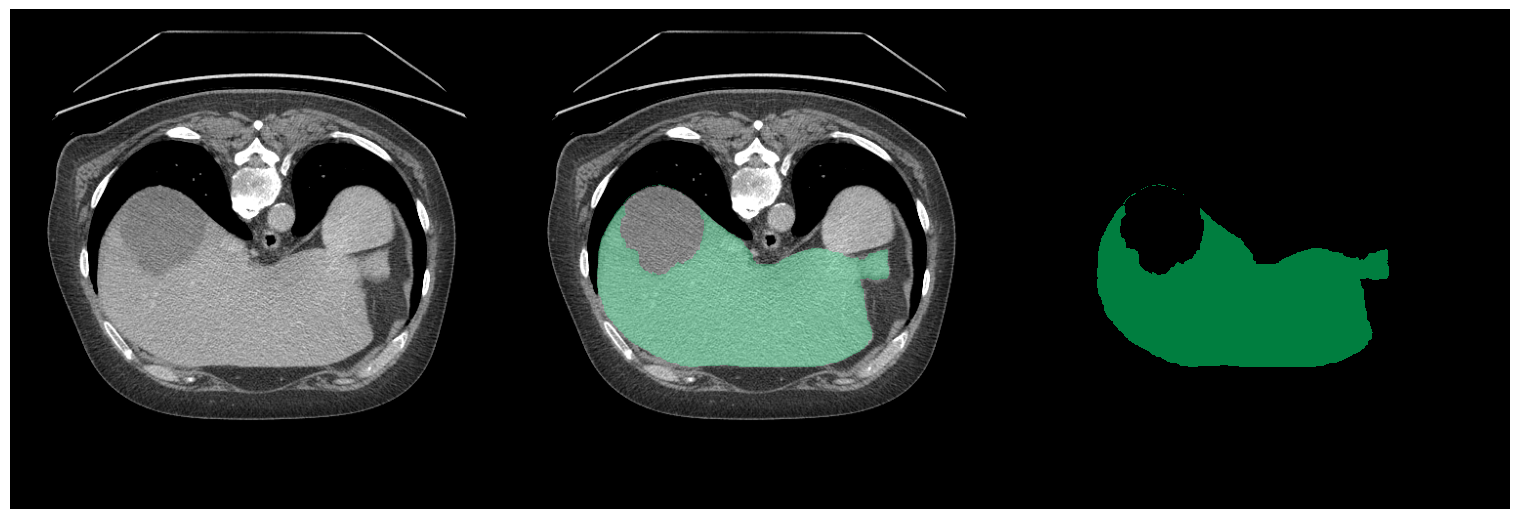

In [20]:
mask_ = (mask_1==1).astype(np.uint8)
best_slide = find_best_slice(image_1, mask_)
image_1 = np.clip(image_1, -200, 250)
print("best slide: ", best_slide)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_visible(False)
visualize_ct_slice(image_1, None, slice_index=best_slide,  ax=axes[0])
visualize_ct_slice(image_1, mask_, slice_index=best_slide, tumor=False, alpha=0.5,  ax=axes[1])
visualize_ct_slice(None, mask_, slice_index=best_slide, tumor=False, alpha=1,  ax=axes[2])

In [21]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/weight/best_metric_*liver*.pth"))

['/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver_1.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSCoTNeXtUNet_liver_msa.pth']


In [22]:
weight_liver = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth"
model_liver = ModelFactory.get_model("unet3d_resnextcot_mcb",in_channels=1, n_classes=1, n_channels=16).to(device)
model_liver.load_state_dict(torch.load(weight_liver))

<All keys matched successfully>

In [23]:
model_liver.eval()
ct_prep, mask_prep = preprocessing_liver(image_1, mask_1)
ct_prep, mask_prep = ct_prep.unsqueeze(0).to(device), mask_prep.unsqueeze(0).to(device)
with torch.no_grad():
  logits = model_liver(ct_prep)
mask_pred = post_trans_stage1(logits.squeeze())
mask_pred = mask_pred.cpu().numpy()
ct_prep = ct_prep.squeeze().cpu().numpy()

In [24]:
image_liver, seg_liver = resize_image(np.expand_dims(ct_prep, axis=0), np.expand_dims(mask_pred, axis=0), target_size=(image_1.shape[0], image_1.shape[1], image_1.shape[2]))
image_liver, seg_liver  = image_liver.squeeze(), seg_liver.squeeze()

In [25]:
mask_full_liver = (mask_1 > 0).astype(np.uint8)

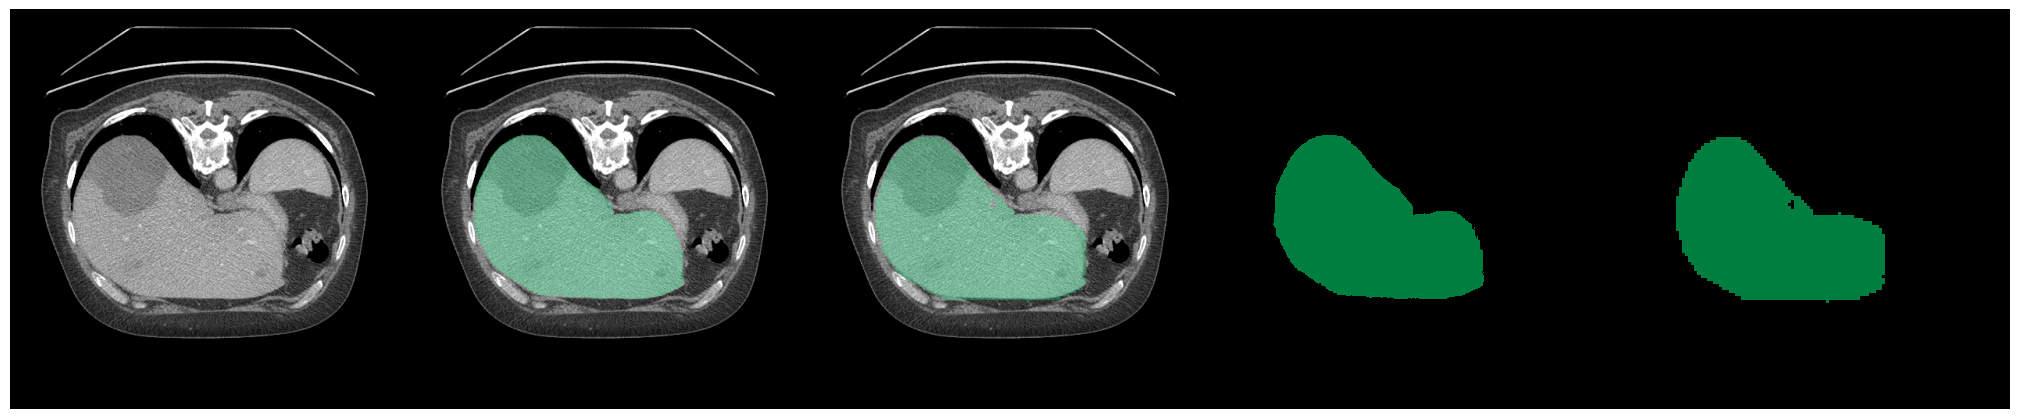

In [27]:
best_slide_pred = find_best_slice(image_liver, seg_liver)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.patch.set_visible(False)
visualize_ct_slice(image_1, None, slice_index=best_slide_pred,  ax=axes[0])
visualize_ct_slice(image_1, mask_full_liver, slice_index=best_slide_pred, tumor=False, alpha=0.5,  ax=axes[1])
visualize_ct_slice(image_1, seg_liver, slice_index=best_slide_pred, tumor=False, alpha=0.5,  ax=axes[2])
visualize_ct_slice(None, mask_full_liver, slice_index=best_slide_pred, tumor=False, alpha=1,  ax=axes[3])
visualize_ct_slice(None, seg_liver, slice_index=best_slide_pred, tumor=False, alpha=1,  ax=axes[4])

In [ ]:
model_liver.eval()
ct_prep, mask_prep = preprocessing_liver(image, mask)
ct_prep, mask_prep = ct_prep.unsqueeze(0).to(device), mask_prep.unsqueeze(0).to(device)
with torch.no_grad():
  logits = model_liver(ct_prep)
mask_pred = post_trans_stage1(logits.squeeze())
mask_pred = mask_pred.cpu().numpy()
ct_prep = ct_prep.squeeze().cpu().numpy()

image_liver, seg_liver = resize_image(np.expand_dims(ct_prep, axis=0), np.expand_dims(mask_pred, axis=0), target_size=(image.shape[0], image.shape[1], image.shape[2]))
image_liver, seg_liver  = image_liver.squeeze(), seg_liver.squeeze()
mask = (mask > 0).astype(np.uint8)

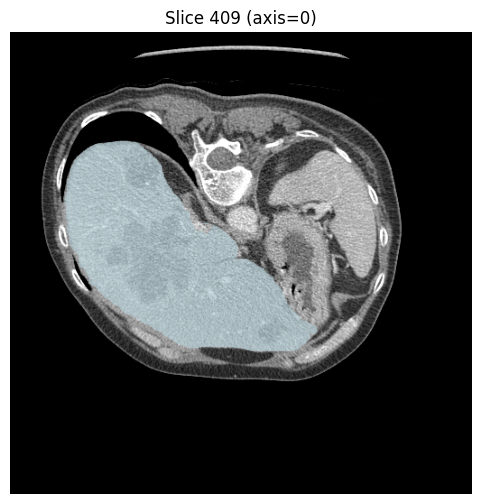

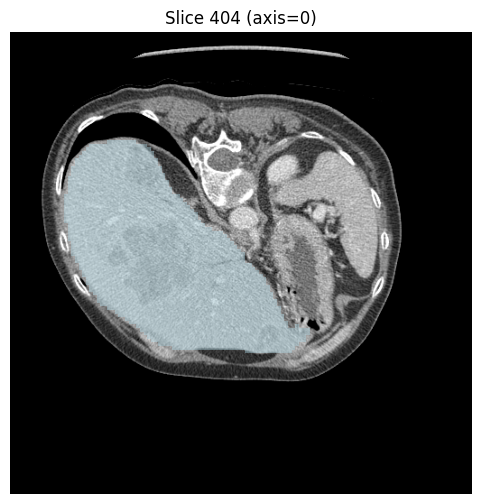

In [ ]:
best_slide_pred = find_best_slice(image_liver, seg_liver)
visualize_ct_slice(image, mask, slice_index=best_slide)
visualize_ct_slice(image, seg_liver, slice_index=best_slide_pred)

## Visualize Tumor

In [ ]:
base_folder = pathlib.Path(config["path_save_dataset_2D"]).resolve()


# Get the list of volume the files in the folder
patient_files = list(base_folder.glob('*patient*.npz'))
str_paths = [str(p) for p in patient_files]
patient_1 = 4
pattern_1 = re.compile(rf"patient_{patient_1}(?=_|\D)")
filtered_1 = [p for p in str_paths if pattern_1.search(p)]

patient_2 = 16
pattern_2 = re.compile(rf"patient_{patient_2}(?=_|\D)")
filtered_2 = [p for p in str_paths if pattern_2.search(p)]

In [ ]:
image_1 = Lits.load_nii(f"{path}/volume-4.nii")
image_1 = np.clip(image_1, -200, 250)
mask_1 = Lits.load_nii(f"{path}/segmentation-4.nii")

image_2 = Lits.load_nii(f"{path}/volume-16.nii")
image_2 = np.clip(image_2, -200, 250)
mask_2 = Lits.load_nii(f"{path}/segmentation-16.nii")

In [ ]:
best_slide_1 = find_best_slice(image_1, mask_1)
best_slide_2 = find_best_slice(image_2, mask_2)
print(best_slide_1, best_slide_2)

508 409


In [ ]:
patient_1_path = "/content/2D_dataset/patient_4_slice_507.npz" # 506, 507, 508
patient_2_path = "/content/2D_dataset/patient_16_slice_409.npz" # 408, 409, 410

In [ ]:
weight_tumor = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet2D_tumor_mcb.pth"
model_tumor = ModelFactory.get_model("unet2d_resnextcot_mcb",in_channels=3, n_classes=1, n_channels=32).to(device)
model_tumor.load_state_dict(torch.load(weight_tumor))

<All keys matched successfully>

In [ ]:
image_tumor_1, mask_tumor_1, liver_mask_1, bbox_1 = preprocessing_tumor(patient_1_path)
image_tumor_2, mask_tumor_2, liver_mask_2, bbox_2 = preprocessing_tumor(patient_2_path)

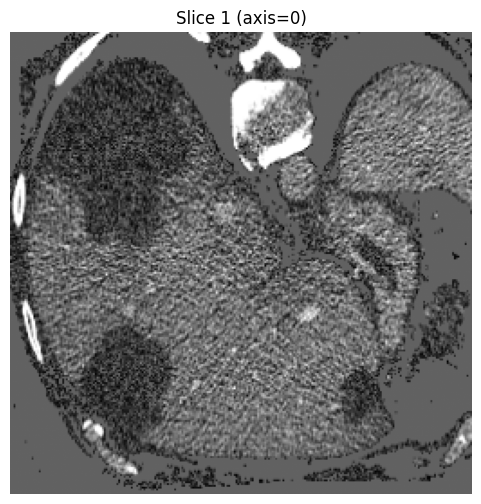

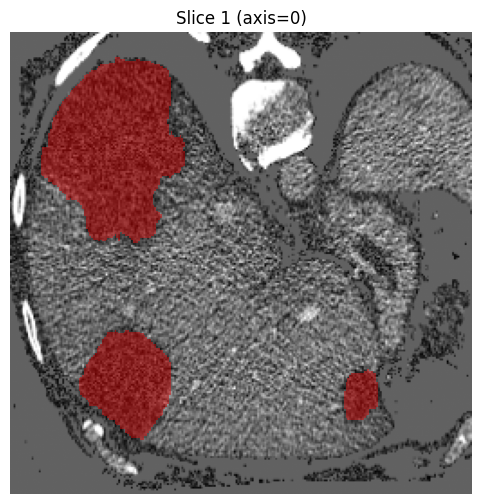

In [ ]:
visualize_ct_slice(image_tumor_1.cpu().numpy(), None, tumor=True, slice_index=1)
visualize_ct_slice(image_tumor_1.cpu().numpy(), mask_tumor_1.cpu().numpy(), tumor=True, slice_index=1)


In [ ]:
model_tumor.eval()
ct_prep_1, mask_prep_1 = image_tumor_1.unsqueeze(0).to(device), mask_tumor_1.unsqueeze(0).to(device)
ct_prep_2, mask_prep_2 = image_tumor_2.unsqueeze(0).to(device), mask_tumor_2.unsqueeze(0).to(device)
with torch.no_grad():
  logits_1 = model_tumor(ct_prep_1)
  logits_2 = model_tumor(ct_prep_2)

mask_pred_1 = post_processing_stage2(logits_1.squeeze()).cpu().numpy()
mask_pred_2 = post_processing_stage2(logits_2.squeeze()).cpu().numpy()

ct_prep_1 = ct_prep_1.squeeze().cpu().numpy()
ct_prep_2 = ct_prep_2.squeeze().cpu().numpy()

In [ ]:
bb = [item for item in liver_masks_bbox if item['patient_id'] in [16, 4]]
bb_1 = [item for item in bb if item['patient_id'] == 4][0]["bbox"][2:6]
bb_2 = [item for item in bb if item['patient_id'] == 16][0]["bbox"][2:6]


In [ ]:
bb_1

[140, 392, 68, 400]

In [ ]:
image_1_2d = image_1[best_slide_1]
image_2_2d = image_2[best_slide_2]
print(image_1_2d.shape, image_2_2d.shape)

(512, 512) (512, 512)


In [ ]:
mask_full_1 = paste_mask_to_full(mask_pred_1.squeeze(), bbox=bb_1, full_shape=image_1_2d.shape)
mask_full_2 = paste_mask_to_full(mask_pred_2.squeeze(), bbox=bb_2, full_shape=image_2_2d.shape)

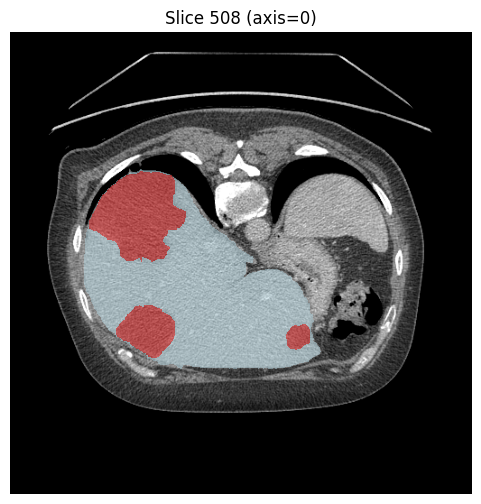

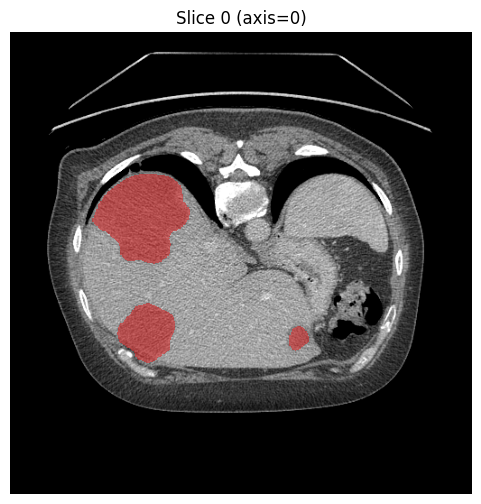

In [ ]:
visualize_ct_slice(image_1, mask_1, slice_index=best_slide_1)
visualize_ct_slice(np.expand_dims(image_1_2d, axis=0), mask_full_1, slice_index=0, tumor=True)

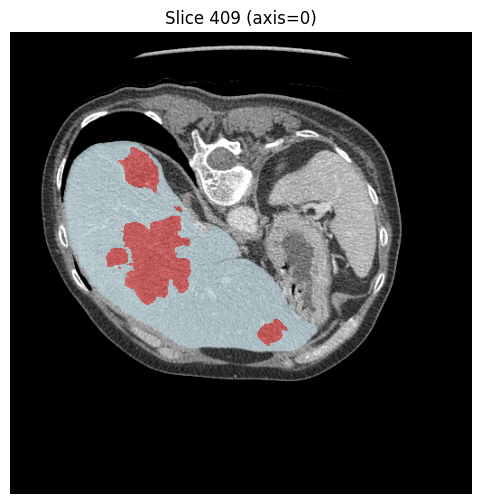

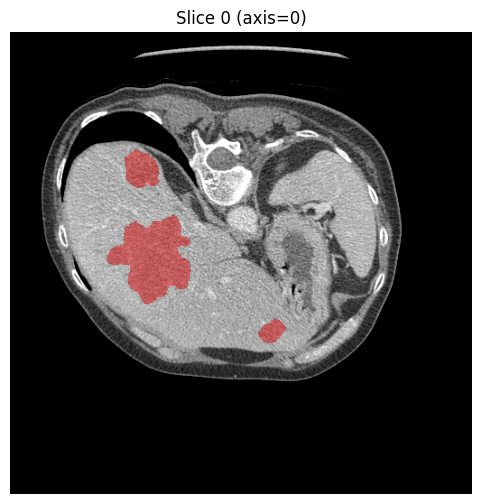

In [ ]:
visualize_ct_slice(image_2, mask_2, slice_index=best_slide_2)
visualize_ct_slice(np.expand_dims(image_2_2d, axis=0), mask_full_2, slice_index=0, tumor=True)